In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.random import randn
import statsmodels.api as sm
from scipy.stats import norm
import scipy.integrate as integrate
from tqdm import tqdm

pio.renderers.default = 'vscode'
pio.templates.default = 'plotly'


Finding the log returns. Dropping the first row in each dataframe as it has no log return

In [2]:
aapl_df = pd.read_csv('AAPL.csv')
btc_df = pd.read_csv('BTC.csv')
gas_df = pd.read_csv('GAS.csv')
aapl_df['date'] = aapl_df['date'].apply(lambda x: pd.to_datetime(x))
btc_df['date'] = btc_df['date'].apply(lambda x: pd.to_datetime(x))
gas_df['Date'] = gas_df['Date'].apply(lambda x: pd.to_datetime(x))

apple_close = aapl_df['Close']
aapl_df['log_income'] = np.log(1 + apple_close.pct_change())
aapl_df = aapl_df[~aapl_df.log_income.isna()]

btc_close = btc_df['Close']
btc_df['log_income'] = np.log(1 + btc_close.pct_change())
btc_df = btc_df[~btc_df.log_income.isna()]

gas_close = gas_df['Close']
gas_df['log_income'] = np.log(1 + gas_close.pct_change())
gas_df = gas_df[~gas_df.log_income.isna()]

btc_df = btc_df.reset_index(drop=True)
aapl_df = aapl_df.reset_index(drop=True)
gas_df = gas_df.reset_index(drop=True)

In [3]:
aapl_df

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,log_income
0,2019-09-24,53.890204,54.246174,52.953959,53.073425,53.073425,124763200,0.0,0.0,-0.004766
1,2019-09-25,53.285552,54.004802,52.941773,53.890209,53.890209,87613600,0.0,0.0,0.015272
2,2019-09-26,53.639082,53.868268,53.353820,53.612263,53.612263,75334000,0.0,0.0,-0.005171
3,2019-09-27,53.770740,53.873145,52.975908,53.351383,53.351383,101408000,0.0,0.0,-0.004878
4,2019-09-30,53.858514,54.755752,53.831695,54.607025,54.607025,103909600,0.0,0.0,0.023263
...,...,...,...,...,...,...,...,...,...,...
862,2023-02-27,147.710007,149.169998,147.449997,147.919998,147.919998,44998500,0.0,0.0,0.008214
863,2023-02-28,147.050003,149.080002,146.830002,147.410004,147.410004,50547000,0.0,0.0,-0.003454
864,2023-03-01,146.830002,147.229996,145.009995,145.309998,145.309998,55479000,0.0,0.0,-0.014348
865,2023-03-02,144.380005,146.710007,143.899994,145.910004,145.910004,52279800,0.0,0.0,0.004121


In [4]:
fig = px.scatter(data_frame=aapl_df, x='date', y='Adj Close', trendline='ols', title='AAPL')
fig.show()


In [5]:
# pdf and cdf of normal distribution
def normal_distr(x, sigma, mu):
    first_mult = 1 / (sigma * np.sqrt(2 * np.pi))
    second_mult = np.exp(-0.5 * ((x-mu) / sigma) ** 2)
    return first_mult * second_mult

def make_cdf(mean, std):
    return lambda x: stats.norm.cdf(x, loc=mean, scale=std)

In [6]:
def bin_search_optimal(X, mu, min_sigma, max_sigma):
    median_sigma_pval = 0
    while max_sigma - min_sigma > 0.0000001:
        median_sigma = min_sigma + (max_sigma-min_sigma) / 2
        _, min_sigma_pval = stats.ks_1samp(X, cdf = make_cdf(mu, min_sigma))
        _, max_sigma_pval = stats.ks_1samp(X, cdf = make_cdf(mu, max_sigma))
        if max_sigma_pval > min_sigma_pval:
            min_sigma = median_sigma
        elif max_sigma_pval < min_sigma_pval:
            max_sigma = median_sigma
        else:
            break
    _, median_sigma_pval = stats.ks_1samp(X, cdf = make_cdf(mu, median_sigma))
    return median_sigma, median_sigma_pval



We are checking, if btc log returns have normal distribution

stats is  0.9643861055374146 
 pvalue for Shapiro (40 samples) is  0.23586057126522064
stats is  0.8816497921943665 
 pvalue for Shapiro (full sample) is  6.439466387363863e-30
pvalue for Kolmogorov-Smirnov (full sample) 1.2893450863689509e-09


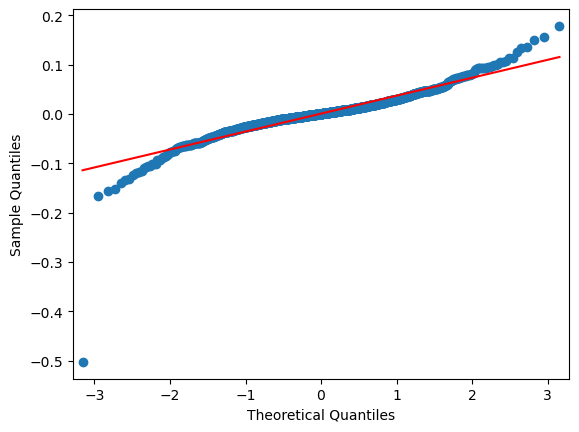

In [13]:
stats_shapiro, pval_shapiro = stats.shapiro(btc_df['log_income'].sample(40, replace=True))
print('stats is ', stats_shapiro, '\n', 'pvalue for Shapiro (40 samples) is ', pval_shapiro)
stats_shapiro_full, pval_shapiro_full = stats.shapiro(btc_df['log_income'])
print('stats is ', stats_shapiro_full, '\n', 'pvalue for Shapiro (full sample) is ', pval_shapiro_full)

stats_ks, pvalue_ks = stats.ks_1samp(btc_df['log_income'], cdf = make_cdf(btc_df['log_income'].mean(), btc_df['log_income'].std()))
print('pvalue for Kolmogorov-Smirnov (full sample)', pvalue_ks)
sm.qqplot(btc_df['log_income'], dist= stats.distributions.norm, line='r');

No, it's not normal. And Q-Q plot shows that our distribution has heavier ends, than normal

Ok, we will try to find such mu and sigma of normal distribution, that maximizely fit our distribution using modification of binary search, that searches for <br/>
the maximum p-value of 1-sample Kolmogorov-Smirnov test for normal distribution.

In [14]:
sigma_btc = btc_df['log_income'].std()
mu_btc = btc_df['log_income'].mean()
optimized_sigma_btc, pval = bin_search_optimal(btc_df['log_income'], mu_btc, 0.001, sigma_btc)  
print('sigma is ', sigma_btc)
print('optimized sigma is ', optimized_sigma_btc)
_, ks_2sample_pval_btc = stats.ks_2samp(btc_df['log_income'], np.random.normal(mu_btc, optimized_sigma_btc, btc_df['log_income'].size))
print('Kolmogorov-Smirnov test for goodness of fit: ', ks_2sample_pval_btc)

sigma is  0.03868677674572917
optimized sigma is  0.027792870960844734
Kolmogorov-Smirnov test for goodness of fit:  0.21421834526536424


2-sample Kolmogorov-Smirnov test shows that the original sample and our optimized sample is still drawn from the same distribution.

In [15]:
_, ks_2sample_pval_btc = stats.ks_2samp(btc_df['log_income'], np.random.normal(mu_btc, optimized_sigma_btc, btc_df['log_income'].size))
print('Kolmogorov-Smirnov test for goodness of fit: ', ks_2sample_pval_btc)

Kolmogorov-Smirnov test for goodness of fit:  0.15110079014885755


Ok, for the level of confidence alpha=0.05, we can be safe to assume H0, that normal distr. with given params and our sample
have been drawn from the same distribution. <br/>
Drawing the histogram of our sample along with our normal distribution PDF plot with mu and optimized sigma.

sigma is  0.03868677674572917
mu is  0.0006633017517867826


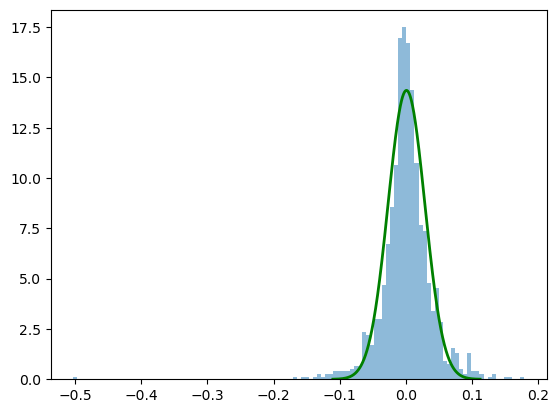

In [16]:
fig, ax = plt.subplots()
ax.hist(btc_df['log_income'], alpha=0.5, bins='auto', density=True, label='Sample log return distribution')
xs_normal_distr = np.linspace(mu_btc - 4*optimized_sigma_btc, mu_btc + 4*optimized_sigma_btc, 1000)
ys_normal_distr = normal_distr(xs_normal_distr, optimized_sigma_btc, mu_btc)
ax.plot(xs_normal_distr, ys_normal_distr, color = 'green', linewidth=2)
print('sigma is ', sigma_btc)
print('mu is ', mu_btc)  

In [33]:
class MyStats:
    # mapping from confidence level in procents to the sigma value of the N(0,1).
    conf_lvl_to_sigma = {90: 1.645, 95: 1.96, 99: 2.58}
    
    @staticmethod
    def get_conf_interval(data, conf_lvl):
        data_mu = np.mean(data)
        data_sigma = np.std(data)
        data_size = len(data)
        return data_mu - (MyStats.conf_lvl_to_sigma[conf_lvl] * data_sigma), data_mu + (MyStats.conf_lvl_to_sigma[conf_lvl] * data_sigma)

    @staticmethod
    def get_t_stats_2_tailed_pval(t, df):
        right_area_probability = 1 - stats.t(df=df-2).cdf(t)
        return right_area_probability * 2

Ok, trying to find confidence interval for mean of BTC log-return using bootstpapping of the mean

90% confidence interval for mean is [0.0014929771367554476, 0.006097176835682756]
95% confidence interval for mean is [0.0010521495060070883, 0.006538004466431115]
99% confidence interval for mean is [0.00018448877247063478, 0.007405665199967569]
mean is  0.003798194272142213
bs mean is  0.0037950769862191017
KS pval is  0.40044874888576376


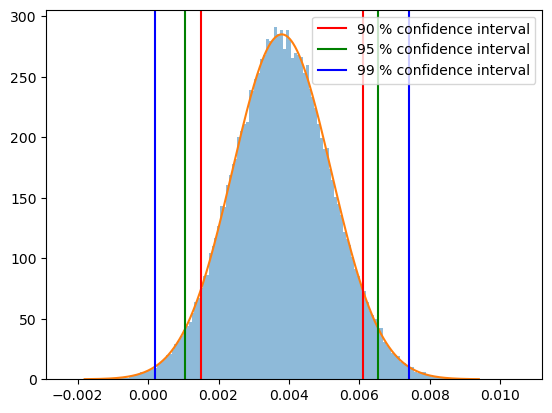

In [27]:
log_return = btc_df['log_income']
log_return_mean = log_return.mean()

sample_size = 634

bs_samples = 100_000
bs_each_size = int(sample_size * 1)

sample = np.random.choice(log_return, sample_size, replace=True)

means = []
for i in range(bs_samples):
    mean = np.random.choice(sample, bs_each_size, replace=True).mean()
    means.append(mean)

fig, ax = plt.subplots()
ax.hist(means, alpha=0.5, bins='auto', density=True)
means_std = np.std(means)
means_normal_x = np.linspace(np.mean(means) - 4*means_std, np.mean(means) + 4*means_std, 1000)
means_normal_y_norm = norm.pdf(means_normal_x, loc=np.mean(means), scale = means_std)
ax.plot(means_normal_x, means_normal_y_norm)


mean_ci_90_lower, mean_ci_90_upper = MyStats.get_conf_interval(means, 90)
mean_ci_95_lower, mean_ci_95_upper = MyStats.get_conf_interval(means, 95)
mean_ci_99_lower, mean_ci_99_upper = MyStats.get_conf_interval(means, 99)
ax.axvline(mean_ci_90_lower, color='red', label='90 % confidence interval')
ax.axvline(mean_ci_90_upper, color='red')
ax.axvline(mean_ci_95_lower, color='green', label='95 % confidence interval')
ax.axvline(mean_ci_95_upper, color='green')
ax.axvline(mean_ci_99_lower, color='blue', label='99 % confidence interval')
ax.axvline(mean_ci_99_upper, color='blue')
ax.legend()
print('90% confidence interval for mean is [{0}, {1}]'.format(mean_ci_90_lower, mean_ci_90_upper))
print('95% confidence interval for mean is [{0}, {1}]'.format(mean_ci_95_lower, mean_ci_95_upper))
print('99% confidence interval for mean is [{0}, {1}]'.format(mean_ci_99_lower, mean_ci_99_upper))
print('mean is ', np.mean(sample))
print('bs mean is ', np.mean(means))
_, pval = stats.ks_1samp(means, make_cdf(np.mean(means), means_std))
print('KS pval is ', pval)

In [34]:
class PearsonCorrelation:
    @staticmethod
    def pearson_correlation(values1, values2) -> int:
        if len(values1) > len(values2):
            values1 = values1[:len(values2)]
        else:
            values2 = values2[:len(values1)]
        n = len(values1)
        numerator = n * np.sum(values1 * values2) - np.sum(values1) * np.sum(values2)
        denominator = np.sqrt((n * np.sum(values1 ** 2) - np.sum(values1) ** 2) * (n * np.sum(values2 ** 2) - np.sum(values2) ** 2))
        return numerator / denominator
    
    @staticmethod
    def pearson_t_stats(r, values1, values2) -> int:
        min_size = len(values1) if len(values1) > len(values2) else len(values2)
        return r * np.sqrt(min_size - 2) / (np.sqrt(1 - r**2))

Pearson correlation between apple LR and btc LR is 0.021809532287096863, p-value (H0-there is NO correlation, H1 - opposite) is 0.5213092703950211


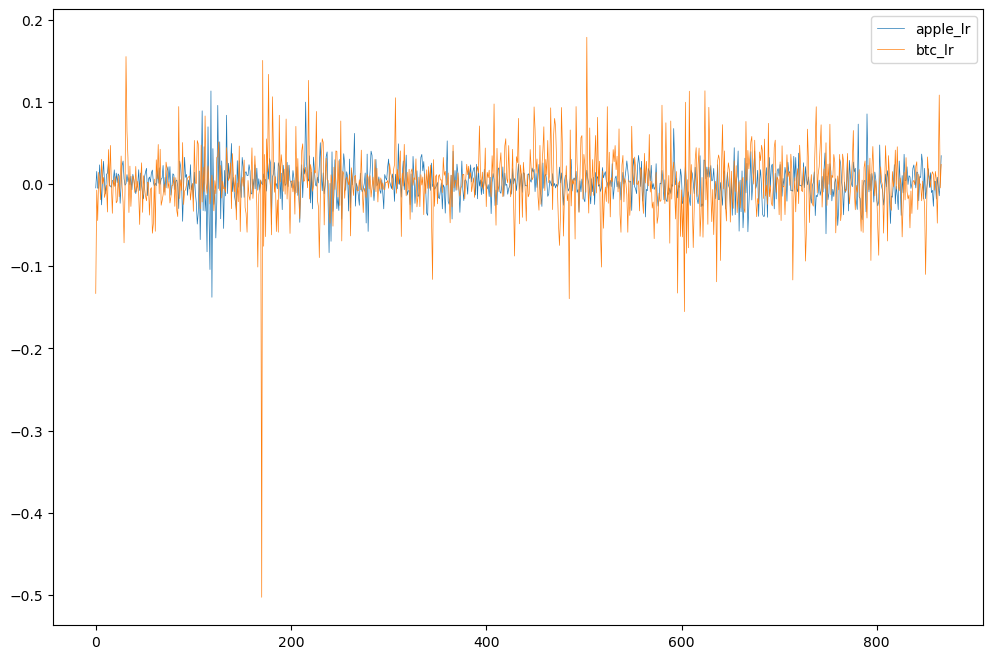

In [36]:
from scipy.stats import pearsonr
min_size = min(len(aapl_df['log_income']), len(btc_df['log_income']))
show_data = pd.DataFrame({'apple_lr': aapl_df['log_income'][:min_size], 'btc_lr': btc_df['log_income'][:min_size]})


show_data['apple_lr'].plot(legend=True, figsize=(12, 8), lw=0.5)
show_data['btc_lr'].plot(legend=True, figsize=(12, 8), lw=0.5)
r = PearsonCorrelation.pearson_correlation(show_data['apple_lr'], show_data['btc_lr'])
t = PearsonCorrelation.pearson_t_stats(r, show_data['apple_lr'], show_data['btc_lr'])
pval = MyStats.get_t_stats_2_tailed_pval(t, df=min_size)
print('Pearson correlation between apple LR and btc LR is {0}, p-value (H0-there is NO correlation, H1 - opposite) is {1}'.format(r, pval))

We clearly see NO corelation at all reasonable confidence levels (alpha=0.01, alpha=0.05, alpha=0.1).

Then, we will try to normalize our aapl and gas log returns using binary search modification to find optimal sigma for our distribution, that maximizes Kolmogorov-Smirnov test p-value. 

In [69]:
aapl_sigma = aapl_df['log_income'].std()
aapl_mu = aapl_df['log_income'].mean()
optimized_sigma_aapl, _ = bin_search_optimal(aapl_df['log_income'], aapl_mu, 0.0001, aapl_sigma * 1.5)
_, ks_2sample_pval_aapl = stats.ks_2samp(aapl_df['log_income'], np.random.normal(aapl_mu, aapl_sigma, aapl_df['log_income'].size))
print('Kolmogorov-Smirnov test for goodness of fit aapl: ', ks_2sample_pval_aapl)
_, ks_aapl_pval_opt = stats.ks_2samp(aapl_df['log_income'], np.random.normal(aapl_mu, optimized_sigma_aapl, aapl_df['log_income'].size))
print('Kolmogorov-Smirnov test for goodness of fit aapl optimized: ', ks_aapl_pval_opt)
print('aapl sigma is', aapl_sigma)
print('aapl optimized sigma is', optimized_sigma_aapl)

gas_sigma = gas_df['log_income'].std()
gas_mu = gas_df['log_income'].mean()
optimized_sigma_gas, _ = bin_search_optimal(gas_df['log_income'], gas_mu, 0.0001, gas_sigma * 1.5)
_, ks_2sample_pval_gas = stats.ks_2samp(gas_df['log_income'], np.random.normal(gas_mu, gas_sigma, gas_df['log_income'].size))
print('Kolmogorov-Smirnov test for goodness of fit gas: ', ks_2sample_pval_gas)
_, ks_gas_pval_opt = stats.ks_2samp(gas_df['log_income'], np.random.normal(gas_mu, optimized_sigma_gas, gas_df['log_income'].size))
print('Kolmogorov-Smirnov test for goodness of fit gas optimized: ', ks_gas_pval_opt)
print('gas sigma is', gas_sigma)
print('gas optimized sigma is', optimized_sigma_gas)

Kolmogorov-Smirnov test for goodness of fit aapl:  0.041272251472620314
Kolmogorov-Smirnov test for goodness of fit aapl optimized:  0.6368057430251138
aapl sigma is 0.022266746953270584
aapl optimized sigma is 0.01820512395650093
Kolmogorov-Smirnov test for goodness of fit gas:  0.011461491660911177
Kolmogorov-Smirnov test for goodness of fit gas optimized:  0.31678805705535973
gas sigma is 0.04754200487020629
gas optimized sigma is 0.03874708206572729


In [70]:
stat1, btc_pval = stats.ks_1samp(btc_df['log_income'], make_cdf(btc_df['log_income'].mean(), btc_df['log_income'].std()))
stat2, aapl_pval = stats.ks_1samp(aapl_df['log_income'], make_cdf(aapl_df['log_income'].mean(), aapl_df['log_income'].std()))
stat3, gas_pval = stats.ks_1samp(gas_df['log_income'], make_cdf(gas_df['log_income'].mean(), gas_df['log_income'].std()))
print('Kolmogorov-Smirnov pval for normality for btc_df is ', btc_pval)
print('Kolmogorov-Smirnov pval for normality for aapl_df is ', aapl_pval)
print('Kolmogorov-Smirnov pval for normality for gas_df is ', gas_pval)

Kolmogorov-Smirnov pval for normality for btc_df is  1.2893450863689509e-09
Kolmogorov-Smirnov pval for normality for aapl_df is  0.0013734002593985663
Kolmogorov-Smirnov pval for normality for gas_df is  0.0021578388573621388


So we can conclude, that there are no raw datasets with normal distribution. So we are using non-parametric Levene test to test hypothesis that variances <br/>
 of raw log-returns are equal.

In [71]:
_, p_value_variance = stats.levene(btc_df['log_income'], aapl_df['log_income'], gas_df['log_income'], center='mean')
print('pvalue for H0 - no significant variance difference between the groups, H1 - opposite: ', p_value_variance)

pvalue for H0 - no significant variance difference between the groups, H1 - opposite:  9.433905009495512e-41


Ok, we do see, that we can be safe to reject H0 with any reasonable significance levels (alpha=0.01, alpha=0.05, alpha=0.01).<br/>
So, our sample distributions are neither normal, nor with the same variance.<br/>
So I decided to bootstrap the mean of each sample and normalize the standard deviation to make data good enough to be suitable for ANOVA.

In [79]:
total_mean_bs_samples = 100_000
each_mean_bs_sample_size_ratio = 1
btc_means = []
aapl_means = []
gas_means = []
for i in tqdm(range(total_mean_bs_samples)):
    btc_mean = np.random.choice(btc_df['log_income'], int(each_mean_bs_sample_size_ratio * btc_df['log_income'].size), replace=True)
    aapl_mean = np.random.choice(aapl_df['log_income'], int(each_mean_bs_sample_size_ratio * aapl_df['log_income'].size), replace=True)
    gas_mean = np.random.choice(gas_df['log_income'], int(each_mean_bs_sample_size_ratio * gas_df['log_income'].size), replace=True)
    btc_means.append(btc_mean.mean())
    aapl_means.append(aapl_mean.mean())
    gas_means.append(gas_mean.mean())

_, p_value_means = stats.f_oneway(btc_means / np.std(btc_means), aapl_means / np.std(aapl_means), gas_means / np.std(gas_means))
print('pvalue for H0 - no significant means difference between the groups, H1 - opposite: ', p_value_means)

100%|██████████| 100000/100000 [00:10<00:00, 9235.46it/s]

pvalue for H0 - no significant means difference between the groups, H1 - opposite:  0.0


Yes, we do have enough evidence to reject the null hypothesis, that means are equal with all reasonable significance levels (alpha=0.01, alpha=0.05, alpha=0.01), <br/>
so we are accepting H1 and stating, that the means of 3 distributions are not equal. But actually this is controversal in some way, because we cannot make <br/>
our sample too small (n<1000 elements), because it's not large enough to be sutable for CLT rule of making our distribution normal, but we cannot make it <br/>
too big, because our ANOVA will actually be more "confident" in its result, then it should be.

But if we just make our data follow normal distribution instead of bootstrapping it, we would get other results... 

In [77]:
normal_btc = np.random.normal(mu_btc, optimized_sigma_btc, btc_df['log_income'].size)
normal_aapl = np.random.normal(aapl_mu, optimized_sigma_aapl, aapl_df['log_income'].size)
normal_gas = np.random.normal(gas_mu, optimized_sigma_gas, gas_df['log_income'].size)
_, p_value_means_normalized = stats.f_oneway(normal_btc / normal_btc.std(), normal_aapl / normal_aapl.std(), normal_gas / normal_gas.std())
print('pvalue for H0 - no significant means difference between the normalized groups, H1 - opposite: ', p_value_means_normalized)

pvalue for H0 - no significant means difference between the normalized groups, H1 - opposite:  0.7108638490634291


And after that I decided to test equality of the means one more time using non-parametric Kruscal-Wallis test, <br/> even though it tests rather equal medians, not equal means,
 but I don't see any other alternatives to test really "raw" data (not normalized and not bootstrapped).

pvalue for H0 - no significant medians difference between the groups, H1 - opposite:  0.8773546188636188


(array([2.13515476e-01, 1.06757738e-01, 0.00000000e+00, 0.00000000e+00,
        1.06757738e-01, 1.06757738e-01, 1.06757738e-01, 3.20273214e-01,
        3.20273214e-01, 2.13515476e-01, 3.20273214e-01, 2.13515476e-01,
        3.20273214e-01, 3.20273214e-01, 7.47304166e-01, 5.33788690e-01,
        4.27030952e-01, 5.33788690e-01, 5.33788690e-01, 1.60136607e+00,
        2.02839702e+00, 2.34867024e+00, 4.80409821e+00, 2.66894345e+00,
        4.27030952e+00, 6.19194881e+00, 5.23112916e+00, 5.65816012e+00,
        7.25952619e+00, 8.43386131e+00, 7.25952619e+00, 1.21703821e+01,
        1.55866298e+01, 1.44122946e+01, 1.48393256e+01, 1.84690887e+01,
        2.10312744e+01, 2.39137333e+01, 2.95718934e+01, 3.12800172e+01,
        3.56570845e+01, 3.74719661e+01, 4.68666470e+01, 4.74004357e+01,
        5.27383226e+01, 6.08519107e+01, 6.81114369e+01, 6.96060452e+01,
        8.38048244e+01, 8.87156803e+01, 9.64022375e+01, 1.03768521e+02,
        1.08892893e+02, 1.17967301e+02, 1.40279668e+02, 1.368634

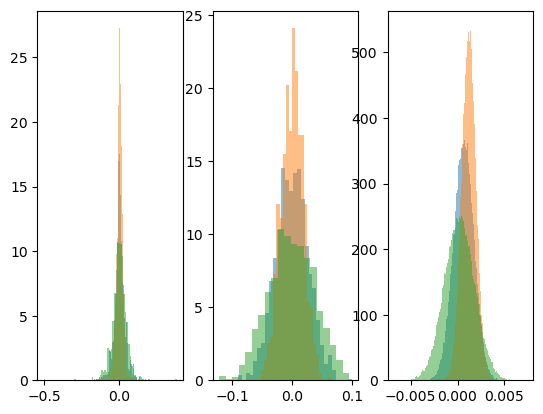

In [88]:
_, kw_pval = stats.kruskal(btc_df['log_income'], aapl_df['log_income'], gas_df['log_income'])
print('pvalue for H0 - no significant medians difference between the groups, H1 - opposite: ', kw_pval)
_, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(btc_df['log_income'], bins='auto', alpha=0.5, density=True)
ax1.hist(aapl_df['log_income'], bins='auto', alpha=0.5, density=True)
ax1.hist(gas_df['log_income'], bins='auto', alpha=0.5, density=True)
ax2.hist(normal_btc, bins='auto', alpha=0.5, density=True)
ax2.hist(normal_aapl, bins='auto', alpha=0.5, density=True)
ax2.hist(normal_gas, bins='auto', alpha=0.5, density=True)
ax3.hist(btc_means, bins='auto', alpha=0.5, density=True)
ax3.hist(aapl_means, bins='auto', alpha=0.5, density=True)
ax3.hist(gas_means, bins='auto', alpha=0.5, density=True)

Okay, we've got controversial result for means and medians equality: means are not equal on bootstrapped means data, means are equal on normalized data, <br/>
 and medians are equal on raw data. Analytically we do see the clear picture on histograms: <br/>
data has almost equal means. I would rather say that means are actually equal, since after normalization of our data, 2 sample KS <br/>
 tests shows that the samples came from the same distribution as their corresponding normally distributed versions. <br/> 
 And moreover we did not change the mean of samples during normalization, but only their deviation. So theese normalized versions shows pretty high p-value for testing of means equality. 
 At the same time bootstrapped data is large enough to be normal, and it overestimates the means difference because of its size (100_000 entries).

btc_df log return abs(mean,median) / max(mean, median) ratio:  0.6303764996231397
aapl_df log return abs(mean,median) / max(mean, median) ratio:  0.025694175046108596
gas_df log return abs(mean,median) / max(mean, median) ratio:  0.7687731639779244


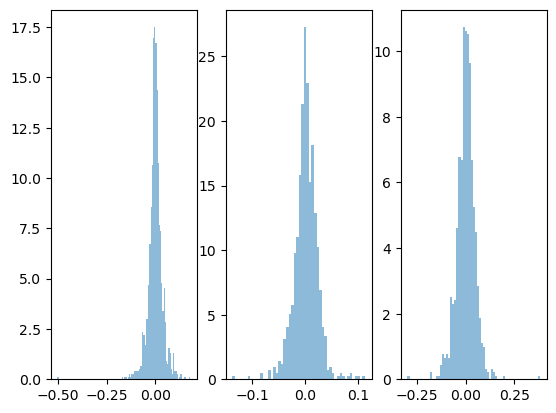

In [87]:
fig, ax = plt.subplots(1,3)
ax[0].hist(btc_df['log_income'], bins='auto', alpha=0.5, density=True)
ax[1].hist(aapl_df['log_income'], bins='auto', alpha=0.5, density=True)
ax[2].hist(gas_df['log_income'], bins='auto', alpha=0.5, density=True)


print('btc_df log return abs(mean,median) / max(mean, median) ratio: ', np.abs(btc_df['log_income'].median() - btc_df['log_income'].mean()) / max(btc_df['log_income'].median(), btc_df['log_income'].mean()))
print('aapl_df log return abs(mean,median) / max(mean, median) ratio: ', np.abs(aapl_df['log_income'].median() - aapl_df['log_income'].mean()) / max(aapl_df['log_income'].mean(), aapl_df['log_income'].median()))
print('gas_df log return abs(mean,median) / max(mean, median) ratio: ', np.abs(gas_df['log_income'].median() - gas_df['log_income'].mean()) / max(gas_df['log_income'].median(), gas_df['log_income'].mean()))

By the way, we do see analytically, that none of the samples are completely symmetric, so means and medians differs. But all of our data are non-symetric, and left-scewed, </br> I would rather say, that if medians are equal with high p-value, means should be aprox. equal too. <br/>This is an additional factor in favor of means equality hypothesis, but
the main factor is high p-value of ANOVA for normalized data.

In [90]:
fig = px.scatter(data_frame=gas_df, x='Date', y='Close', trendline='ols', title='GAS(N.NG)')
fig.show()

In [ ]:
# на основе Close извлеките логарифмическую доходность BTC task1, ответ – мю и сигма
# проверьте распределение получившихся данных BTC task2, ответ yes/no 
# возмонжо попробуйте их (BTC) нормализовать task3, ответ – mu и sigma
# попробуйте предположить по подвыборке размером 634 дней среднее значение для доходностей (BTC) на уровне 90 95 99 – task 4, ответ – val + [a;b]
# проверьте корреляцию доходностей BTC & AAPL – task5, ответ – yes/no
# проверьте гипотезу о равенствен средних и дисперсии доходностей BTC & AAPL & GAS – task6, ответ – yes/no

In [92]:
ANSWERS = {
    'tasks' : {
        'task1_mu' : {
            "answer" : 0.0006633017517867826
        }, 
        'task1_sigma' : {
            "answer" : 0.03868677674572917
        }, 
        'task2_normal' : {
            "answer": 'no',
            "explaination" : '''
            Имеет форму колокола, и при alpha=0.05 и размере выборки в 40 элементов проходит тест на нормальность Шапиро-Вилка:
             1. p-value не сильно значимо: 0.556029736995697 > alpha;
            однако в полной выборке из 1250 значений имеет p-value=6.439466387363863e-30 и не соответствует рекомендуемому условию применимости теста N<50.
            Тест Колмогорова-Смирнова может быть применен ко всей выборке, так как выборка в 1250 значений соответствует условию применимости теста: N > 50:
                1. p-value сильно значимо: 1.2893450863689509e-09 < alpha;
            И хотя аналитически Q-Q plot для нормального распределения не выглядит, как полностью нелинейный и имеет отклонения лишь в хвосте, что указывает на то, что 
            плотность распределения log return имеет более "тяжелые хвосты", чем нормальное распределение,
              в целом можно сказать, что распределение log return похоже на распределение из Гауссова семейства, но им не является.
             '''
        }, 
        'task3_mu' : {
            "answer" : 0.0006633017517867826,
        }, 
        'task3_sigma' : {
            "answer" : 0.027792870960844734,
            "explaination": '''
            Эмпирически через модификацию бинарного поиска мы нашли макс. pvalue для normalized_sigma и mu сэмпла через 1-sample тест Колмогорова-Смирнова.
            '''
        }, 
        'task4_90' : {
            "answer" : -0.0012035089172451263
        }, 
        'task4_90_int' : {
            "answer" : [-0.00447063998957761, 0.0020636221550873572]
        }, 
        'task4_95' : {
            "answer" : -0.0012035089172451263
        }, 
        'task4_95_int' : {
            "answer" : [-0.005096260833215745, 0.0026892429987254926]
        }, 
        'task4_99' : {
            "answer" : -0.0012035089172451263
        }, 
        'task4_99_int' : {
            "answer" : [-0.006327641541328899, 0.003920623706838647]
        }, 
        'task5_corr' : {
            "answer" : "no"
        },
        'task6_corr_mu' : {
            "answer" : "yes"
        },
        'task6_corr_sigma' : {
            "answer" : "no"
        }
    }
}


In [93]:
import yaml
yaml_result = yaml.dump(ANSWERS)

print(yaml_result)

with open(f"hw03.yaml", "w") as f:
    f.write(yaml_result)

tasks:
  task1_mu:
    answer: 0.0006633017517867826
  task1_sigma:
    answer: 0.03868677674572917
  task2_normal:
    answer: 'no'
    explaination: "\n            \u0418\u043C\u0435\u0435\u0442 \u0444\u043E\u0440\
      \u043C\u0443 \u043A\u043E\u043B\u043E\u043A\u043E\u043B\u0430, \u0438 \u043F\
      \u0440\u0438 alpha=0.05 \u0438 \u0440\u0430\u0437\u043C\u0435\u0440\u0435 \u0432\
      \u044B\u0431\u043E\u0440\u043A\u0438 \u0432 40 \u044D\u043B\u0435\u043C\u0435\
      \u043D\u0442\u043E\u0432 \u043F\u0440\u043E\u0445\u043E\u0434\u0438\u0442 \u0442\
      \u0435\u0441\u0442 \u043D\u0430 \u043D\u043E\u0440\u043C\u0430\u043B\u044C\u043D\
      \u043E\u0441\u0442\u044C \u0428\u0430\u043F\u0438\u0440\u043E-\u0412\u0438\u043B\
      \u043A\u0430:\n             1. p-value \u043D\u0435 \u0441\u0438\u043B\u044C\
      \u043D\u043E \u0437\u043D\u0430\u0447\u0438\u043C\u043E: 0.556029736995697 >\
      \ alpha;\n            \u043E\u0434\u043D\u0430\u043A\u043E \u0432 \u043F\u043E\
      \u